In [204]:
# Clear variables
%reset

### Libraries

In [ ]:
import pandas as pd
import pm4py
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz-11.0.0-win64/bin/'
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint


### Loading data

In [2]:
log_df = pd.read_csv('data\\sepsis cases.csv', sep=',')
log_df['@@case_index'] = log_df['@@case_index'].apply(str)
log_df.rename(columns={'@@case_index': 'case:concept:name', 'case:concept:name': 'Case Name'}, inplace=True)
log_df['time:timestamp']= pd.to_datetime(log_df['time:timestamp'])
# Convert column to numeric, turning 'nan' strings to NaN values

log_df['Leucocytes'] = pd.to_numeric(log_df['Leucocytes'], errors='coerce')
log_df['LacticAcid'] = pd.to_numeric(log_df['LacticAcid'], errors='coerce')


### Studying data

In [37]:
activities = pm4py.get_event_attribute_values(log_df, "concept:name")
pprint(activities)


{'Admission IC': 117,
 'Admission NC': 1182,
 'CRP': 3262,
 'ER Registration': 1050,
 'ER Sepsis Triage': 1049,
 'ER Triage': 1053,
 'IV Antibiotics': 823,
 'IV Liquid': 753,
 'LacticAcid': 1466,
 'Leucocytes': 3383,
 'Release A': 671,
 'Release B': 56,
 'Release C': 25,
 'Release D': 24,
 'Release E': 6,
 'Return ER': 294}


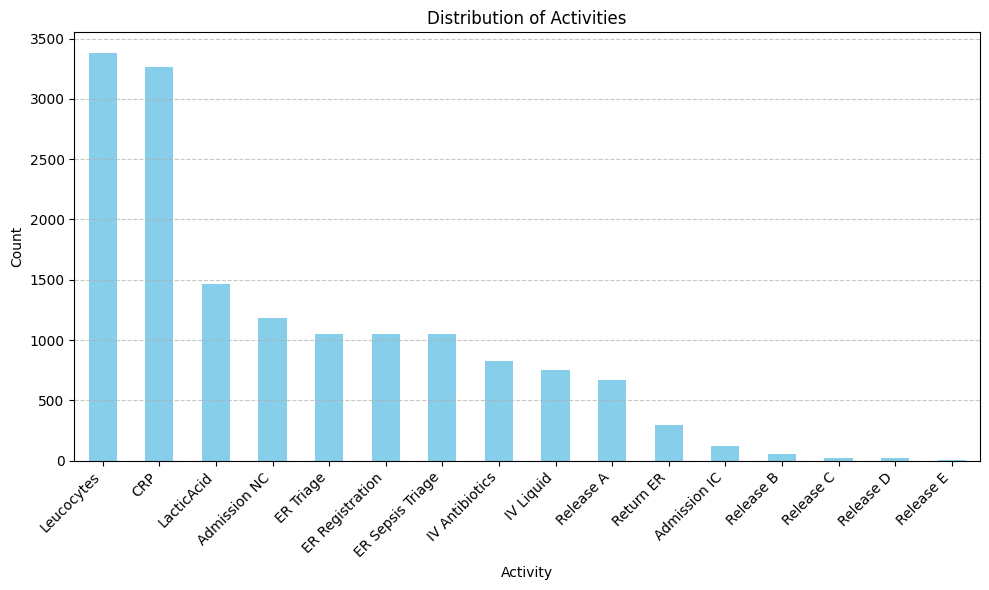

In [4]:
# Count frequency of activties

grouped_counts = log_df.groupby('concept:name').size().sort_values(ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
grouped_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Activities')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
activities

Nmber of events: 15214
Number of cases: 1050
Start activities: {'ER Registration': 995, 'Leucocytes': 18, 'IV Liquid': 14, 'CRP': 10, 'ER Sepsis Triage': 7, 'ER Triage': 6}
End activities: {'Release A': 393, 'Return ER': 291, 'IV Antibiotics': 87, 'Release B': 55, 'ER Sepsis Triage': 49, 'Leucocytes': 44, 'CRP': 41, 'LacticAcid': 24, 'Release C': 19, 'Admission NC': 14, 'Release D': 14, 'IV Liquid': 12, 'Release E': 5, 'ER Triage': 2}


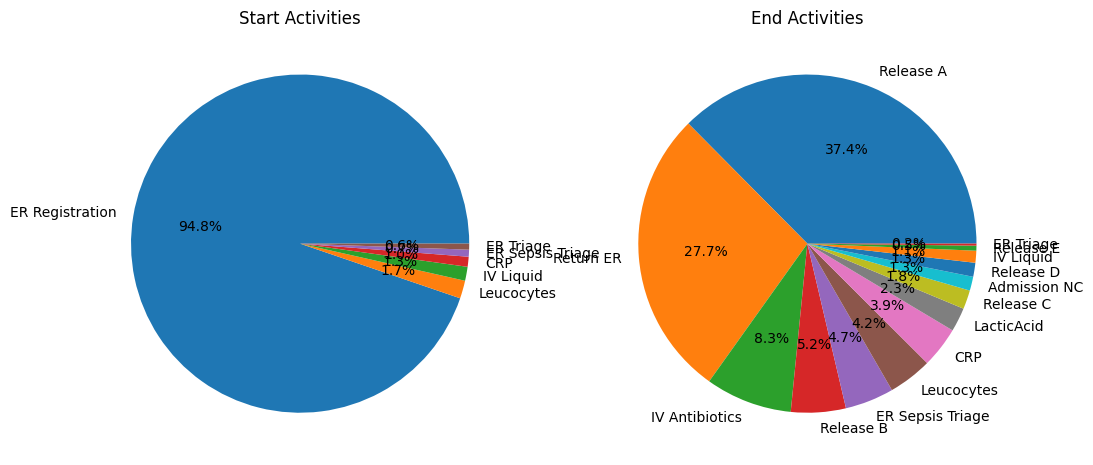

In [5]:
num_events = len(log_df)
num_cases = len(log_df['case:concept:name'].unique())
print("Nmber of events: {}\nNumber of cases: {}".format(num_events, num_cases))

start_activities = pm4py.get_start_activities(log_df)
end_activities = pm4py.get_end_activities(log_df)
start_activities =  dict(sorted(start_activities.items(), key=lambda item: item[1], reverse=True))
end_activities =  dict(sorted(end_activities.items(), key=lambda item: item[1], reverse=True))
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot pie chart for start activities
ax1.pie(start_activities.values(), labels=start_activities.keys(), autopct='%1.1f%%')
ax1.set_title('Start Activities')

# Plot pie chart for end activities
ax2.pie(end_activities.values(), labels=end_activities.keys(), autopct='%1.1f%%')
ax2.set_title('End Activities')

plt.show()

In [88]:
filtered_log_dfq = pm4py.filter_start_activities(log_df, ['ER Registration'])
filtered_log_dfq = pm4py.filter_end_activities(filtered_log_dfq, ['IV Antibiotics'])

print("Given {} total cases in the log we have {} cases whose final activity is 'IV Antibiotics'".format(num_cases, len(filtered_log_dfq['case:concept:name'].unique())))

Given 1050 total cases in the log we have 82 cases whose final activity is 'IV Antibiotics'


In [89]:
# Filter the DataFrame for rows where @@classifier is 'ER Registration'
filtered_log_dfw = log_df[log_df['@@classifier'] == 'ER Registration']

# Select Diagnostic columns
diagnostic_columns = filtered_log_dfw.filter(regex='^Diagnostic.*')

# Initialize a dictionary to hold the counts
counts = {}

for col in diagnostic_columns.columns:
    value_counts = diagnostic_columns[col].value_counts(dropna=False)
    counts[col] = {
        'True': value_counts.get(True, 0),
        'False': value_counts.get(False, 0),
    }

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame(counts).T.fillna(0)
result_df


,True,False
DiagnosticBlood,823,227
DiagnosticArtAstrup,297,753
DiagnosticIC,848,202
DiagnosticSputum,29,1021
DiagnosticLiquor,5,1045
DiagnosticOther,10,1040
DiagnosticXthorax,785,265
DiagnosticUrinaryCulture,476,574
DiagnosticLacticAcid,804,246
DiagnosticUrinarySediment,519,531


### Filtering data
- Incomplete cases according to start and end activity
- Incomplete cases according to activity 'ER Registration' and basic medical procedures
- Incomplete cases according to Leucocytes and CRP measurements, that are NaN (Not a Number) in corresponding activities
- (?) checking if any case lasts less than 1 hour

In [6]:
# Incomplete cases according to start and end activity

filtered_log_df = pm4py.filter_end_activities(log_df, ['Release A', 'Release B', 'Release E', 'Release C', 'Release D', 'Return ER', 'IV Antibiotics'])
# filtered_log_df = pm4py.filter_end_activities(log_df, ['Release A', 'Release B', 'Release E', 'Release C', 'Release D', 'Return ER'])
filtered_log_df = pm4py.filter_start_activities(filtered_log_df, ['ER Registration', 'ER Sepsis Triage', 'ER Triage'])
# filtered_log_df = pm4py.filter_start_activities(filtered_log_df, ['ER Registration'])

print("Given {} total cases in the log we have {} cases that comply with constraints for complete cases according to start and end activity".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))

Given 1050 total cases in the log we have 827 cases that comply with constraints for complete cases according to start and end activity


In [7]:
# Incomplete cases according to activity ‘ER Registration’ and basic medical procedures

filtered = filtered_log_df[filtered_log_df['@@classifier'] == 'ER Registration']
# Count the number of cases where none of blood test was done or the basic diagnostic IC
logical_sum_filter = (filtered[['DiagnosticBlood', 'DiagnosticIC', 'DiagnosticLacticAcid', 'DiagnosticArtAstrup']].any(axis=1) == False)
uncompleted_ER_Registration = logical_sum_filter.sum()

print("Given {} total cases in the log we have {} cases that passed incomplete ER Registration".format(num_cases, uncompleted_ER_Registration))

# Get the unique values from the 'case:concept:name' column
unique_cases = filtered[logical_sum_filter]['case:concept:name'].unique()
filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(unique_cases)]

print("Given {} total cases in the log we have {} cases comply the constraints according to start/end activity and completeness of medical procedures in ER Registration activity".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))



Given 1050 total cases in the log we have 85 cases that passed incomplete ER Registration
Given 1050 total cases in the log we have 742 cases comply the constraints according to start/end activity and completeness of medical procedures in ER Registration activity


In [8]:
# Incomplete cases according to Leucocytes and CRP measurements, that are NaN in corresponding activities
leucocytes_nan_cases = filtered_log_df[ filtered_log_df['concept:name'] == 'Leucocytes' ][ ['Leucocytes', 'case:concept:name'] ]
nan_leucocytes_cases = leucocytes_nan_cases[leucocytes_nan_cases['Leucocytes'].isna()]
unique_nan_leucocytes_cases = nan_leucocytes_cases['case:concept:name'].unique()

print("Given {} total cases in the log we have {} cases passed incomplete Leucocytes measurement, giving unknown value".format(num_cases, len(unique_nan_leucocytes_cases)))

crp_nan_cases = filtered_log_df[filtered_log_df['concept:name'] == 'CRP'][['CRP', 'case:concept:name']]
nan_crp_cases = crp_nan_cases[crp_nan_cases['CRP'].isna()]
unique_nan_crp_cases = nan_crp_cases['case:concept:name'].unique()

print("Given {} total cases in the log we have {} cases passed incomplete Leucocytes measurement, giving unknown value".format(num_cases, len(unique_nan_crp_cases)))

filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(unique_nan_leucocytes_cases)]
filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(unique_nan_crp_cases)]

print("Common cases for CRP and Leucocytes:",  len(set(unique_nan_leucocytes_cases) & set(unique_nan_crp_cases)))

print("Given {} total cases in the log we have {} cases comply the constraints according to start/end activity, completeness of medical procedures in ER Registration activity and completeness of Leucocytes and CRP measurements".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))


Given 1050 total cases in the log we have 23 cases passed incomplete Leucocytes measurement, giving unknown value
Given 1050 total cases in the log we have 56 cases passed incomplete Leucocytes measurement, giving unknown value
Common cases for CRP and Leucocytes: 10
Given 1050 total cases in the log we have 673 cases comply the constraints according to start/end activity, completeness of medical procedures in ER Registration activity and completeness of Leucocytes and CRP measurements


There is at least one case that lasts lower than 1 hour


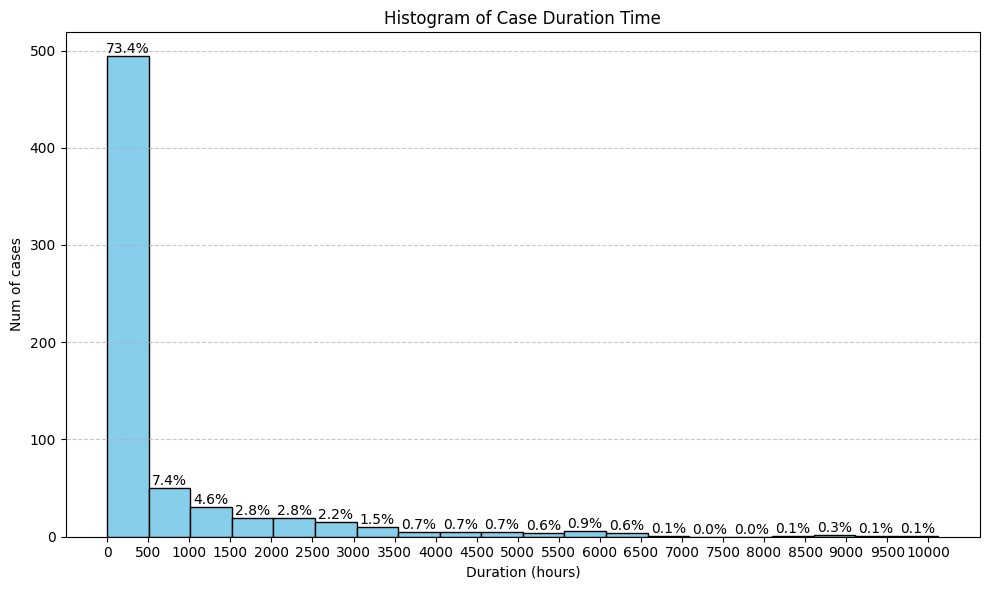

In [9]:
# Case duration
case_durations = pm4py.get_all_case_durations(filtered_log_df, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
case_durations_hours = [duration / (3600) for duration in case_durations]
case_durations_hours.sort(reverse=False)

if any(duration < 1 for duration in case_durations_hours):
    print("There is at least one case that lasts lower than 1 hour")
else:
    print("All cases are longer than 1 hour")

# Plotting the histogram
plt.figure(figsize=(10, 6))
# plt.hist(case_durations_hours, bins=20, color='skyblue', edgecolor='black')
n, bins, patches = plt.hist(case_durations_hours, bins=20, color='skyblue', edgecolor='black')

plt.title('Histogram of Case Duration Time')
plt.xlabel('Duration (hours)')
plt.ylabel('Num of cases')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(np.arange(0, max(case_durations_hours) + 1, 500))

# Add percentage labels on the bars
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    percentage = '{:.1f}%'.format(100 * y / len(case_durations_hours))
    plt.text(x, y, percentage, ha='center', va='bottom')
plt.show()

In [29]:
current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Construct filename with timestamp
filename = f"data\\sepsis_filtered_data_{current_timestamp}.csv"
filtered_log_df.to_csv(filename, index=False)

## Variant Analysis

In [12]:
filtered_log = log_converter.apply(filtered_log_df)
variants = pm4py.get_variants(filtered_log)
variants_lengths = {key: len(value) for key, value in variants.items()}
sorted_variants_lengths = dict(sorted(variants_lengths.items(), key=lambda item: item[1], reverse=True))
for i, (key, length) in enumerate(sorted_variants_lengths.items()):
    print(f"Number of cases of each variant: {length} '\n' {key} ")
    if i == 10:  # Stop after printing the first 5 elements
        break


Number of cases of each variant: 13 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'CRP', 'LacticAcid', 'Leucocytes', 'IV Liquid', 'IV Antibiotics') 
Number of cases of each variant: 8 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Liquid', 'IV Antibiotics') 
Number of cases of each variant: 7 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'LacticAcid', 'CRP', 'IV Liquid', 'IV Antibiotics') 
Number of cases of each variant: 4 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'IV Liquid', 'CRP', 'Leucocytes', 'LacticAcid', 'IV Antibiotics') 
Number of cases of each variant: 4 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'CRP', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'Release A') 
Number of cases of each variant: 4 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Liquid', 'IV Antibiotics', 'Admission NC', '

In [ ]:
## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization

## Convert to log format
filtered_log = log_converter.apply(filtered_log_df)
#Create graph from log
dfg = dfg_discovery.apply(filtered_log)
# Visualise
gviz = dfg_visualization.apply(dfg, log=filtered_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

In [81]:
# Between Filter

a = pm4py.filter_between(filtered_log_df, "ER Registration", "ER Triage")
b = pm4py.filter_between(filtered_log_df, "ER Triage", "ER Sepsis Triage")
c = pm4py.filter_between(filtered_log_df, "ER Registration", "ER Sepsis Triage")
# y = pm4py.filter_between(filtered_log_df, "CRP", "Leucocytes")
print(len(a['case:concept:name'].unique()))
print(len(b['case:concept:name'].unique()))
print(len(c['case:concept:name'].unique()))
print('\n')


667
660
667




#### Rework Filter

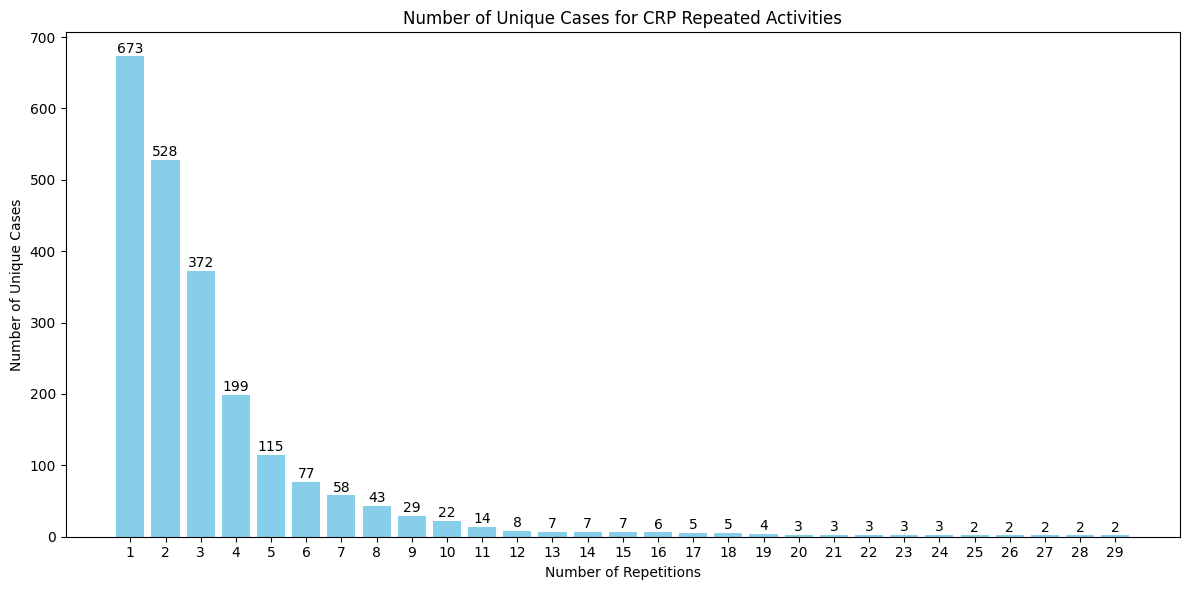

In [80]:
# CRP activity - repetition

min = 1
max = 30
crp_repetitions_num = np.arange(min, max, 1)
crp_repeated = []
for i in crp_repetitions_num:
    d = pm4py.filter_activities_rework(filtered_log_df, "CRP",i)
    crp_repeated.append(len(d['case:concept:name'].unique()))

# Plotting the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(crp_repetitions_num, crp_repeated, color='skyblue')
plt.xlabel('Number of Repetitions')
plt.ylabel('Number of Unique Cases')
plt.title('Number of Unique Cases for CRP Repeated Activities')
plt.xticks(ticks=np.arange(min, max, 1))  # Adjust ticks for better readability
plt.tight_layout()

# Adding annotations to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

# Show the plot
plt.show()

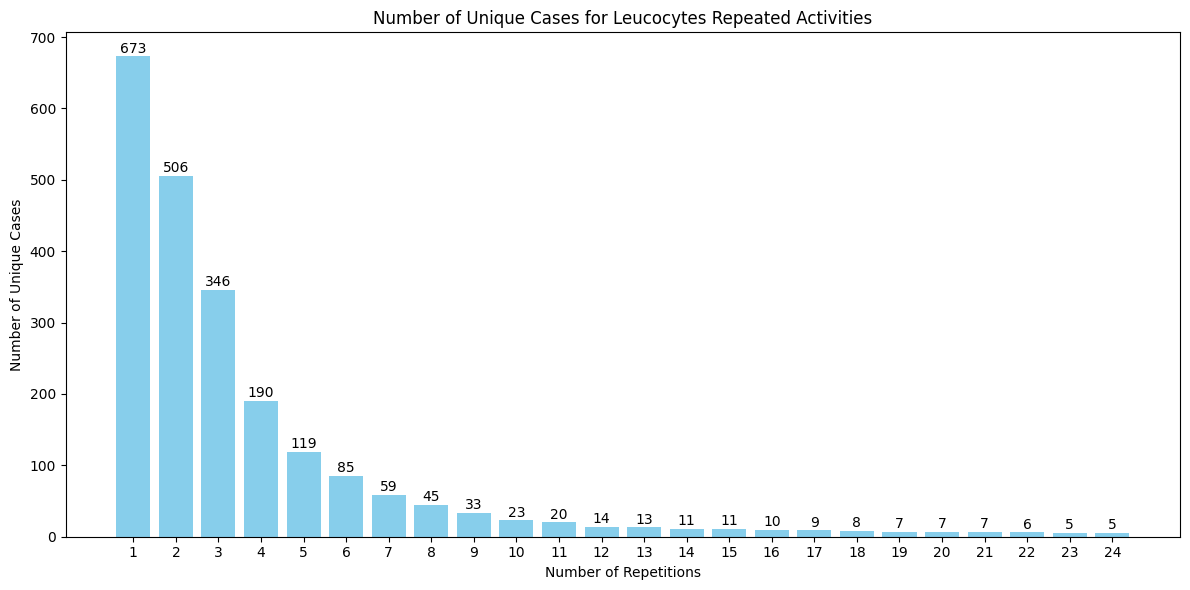

In [88]:
# CRP activity - repetition

min = 1
max = 30
leuc_repetitions_num = np.arange(min, max, 1)
leuc_repeated = []
for i in leuc_repetitions_num:
    d = pm4py.filter_activities_rework(filtered_log_df, "Leucocytes",i)
    leuc_repeated.append(len(d['case:concept:name'].unique()))
# Plotting the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(leuc_repetitions_num, leuc_repeated, color='skyblue')
plt.xlabel('Number of Repetitions')
plt.ylabel('Number of Unique Cases')
plt.title('Number of Unique Cases for Leucocytes Repeated Activities')
plt.xticks(ticks=np.arange(min, max, 1))  # Adjust ticks for better readability
plt.tight_layout()

# Adding annotations to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

# Show the plot
plt.show()

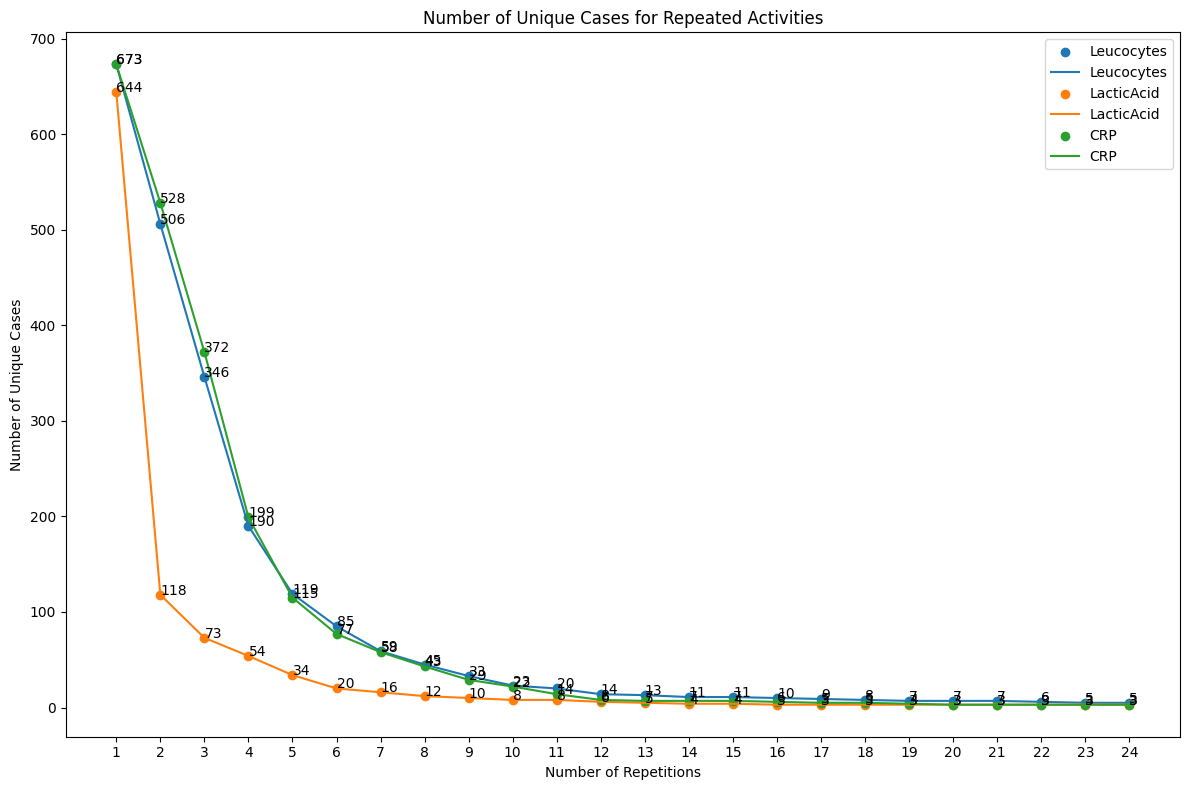

In [97]:
# Define the range
min_value = 1
max_value = 25

# Generate the array
repetitions_num = np.arange(min_value, max_value, 1)

# List of columns to process
columns = ["Leucocytes", "LacticAcid", "CRP"]

# Dictionary to store the results
results = {column: [] for column in columns}

# Assuming filtered_log_df is your DataFrame
for column in columns:
    for i in repetitions_num:
        d = pm4py.filter_activities_rework(filtered_log_df, column, i)
        results[column].append(len(d['case:concept:name'].unique()))

# Plotting the results for each column
plt.figure(figsize=(12, 8))

for column in columns:
    plt.scatter(repetitions_num, results[column], label=column)
    plt.plot(repetitions_num, results[column], label=column)
    for rep_num, result in zip(repetitions_num, results[column]):
        plt.annotate(result, (rep_num, result))

plt.xlabel('Number of Repetitions')
plt.ylabel('Number of Unique Cases')
plt.title('Number of Unique Cases for Repeated Activities')
plt.legend()
plt.xticks(ticks=np.arange(min_value, max_value, 1))  # Adjust ticks for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Inductive Miner

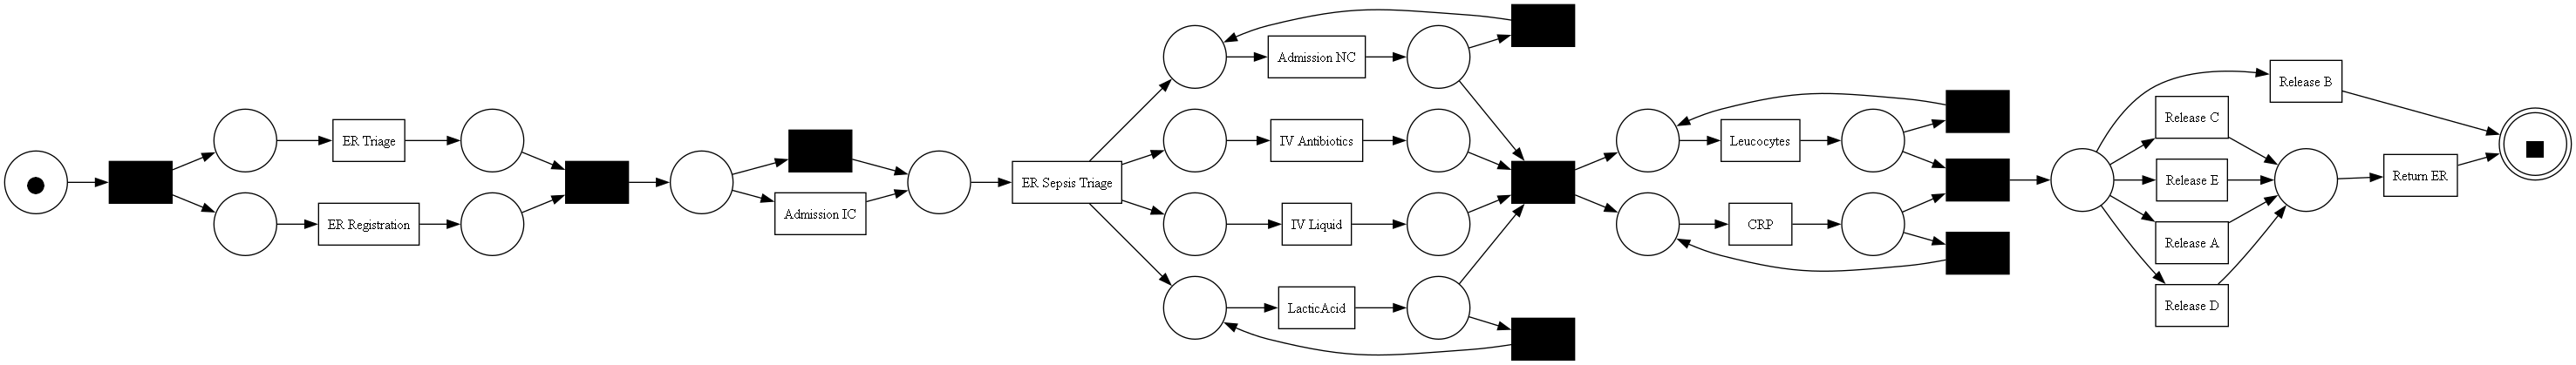

In [21]:
# Discover the model with Inductive Miner

net, im, fm = pm4py.discover_petri_net_inductive(filtered_log_df, noise_threshold= 0.7)
pm4py.view_petri_net(net, im, fm, format='png')


In [23]:
pm4py.get_start_activities(filtered_log_df, activity_key='concept:name')
pm4py.get_end_activities(filtered_log_df, activity_key='concept:name')


{'Release A': 309,
 'IV Antibiotics': 77,
 'Return ER': 227,
 'Release B': 37,
 'Release E': 2,
 'Release C': 13,
 'Release D': 8}

In [ ]:
# Discover the model with Inductive Miner

filtered_log = log_converter.apply(filtered_log_dfq)
#Create graph from log
dfg = dfg_discovery.apply(filtered_log)
# Visualise
gviz = dfg_visualization.apply(dfg, log=filtered_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)